# Assignment 6: RNN Implementation
-------------------
**Dr. Dave Wanik - University of Connecticut**
A weather-based energy forecasting homework.

* **Your Name Here:** Gauthami
* **Your NetID Here:** gah23002

Energy demand forecasting as a function of weather data is an extremely interesting and relevant topic.

I've given you a curated (mostly?) clean dataset that you can use to predict `df['Demand']` as a function of the weather variables.

Of course, you cannot use the df[`Datetime`] column directly into the model - but you can feature engineer the column to make features temporal features for modeling like Julian day of year (0-365), week of year, and number of years since 2012.

**Sorting: (5 pts)**
Sort the data from oldest to newest.

**Cleaning: (10 pts)**
Describe and impute (or drop) the missing values using an appropriate method. At this time, you are welcome to perform feature engineering (optional).

**Process as a 3D tensor: (10 pts)**
Process the data as a 3D tensor with a lookback of your choice (use a value greater than or equal to 12).

**Model Architecure: (10 pts)**
You must use a model with:
* at least two recurrent layers
* at least one convolution layer
* dropout (recurrent or between Dense layers)
* appropriate activation functions

**Experiments: (15 pts each, 30 pts total)**
Freeze the model architecutre and perform a *walk-forward validation* where:
* the first 50k samples predict the remaining ~46k samples
* the first 80k samples predict the remaining ~16k samples

Walk-forward validation is very common to use on the job - it shows how your model (ideally) gets better over time as it gets more data to use. Use subheads

**Evaluation (15 points each, 30 pts total)**
Evaluate your model for each of these experiments - hopefully, your model should improve as you give it more data to use! But that depends on your choice of architecture. You should have:
* quantitative error metrics (mean absolute error and others)
* scatterplots of actual vs. predicted
* time series plots of actual vs. predicted

You should also compare to baseline model like persistence (assume today's energy usage is the same as yesterday's - requires you to shift by 24... ask on discussion board if questions!) or ignore the sequence data and treat this as a 2D problem (a regular supervised learning problem!)

**Conclusions (5 pts total)**
* What did you learn from this assignment? Did your walk-forward validation work as you expected it to?
* What else would you do differently next time?
* At least five great bullets please.

# **Importing the modules**

In [2]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# https://drive.google.com/file/d/1jdTV2Fwcnv0Sxl3v2hSkdupJaaLvDOIZ/view?usp=sharing
!gdown 1jdTV2Fwcnv0Sxl3v2hSkdupJaaLvDOIZ

Downloading...
From: https://drive.google.com/uc?id=1jdTV2Fwcnv0Sxl3v2hSkdupJaaLvDOIZ
To: /content/BDL_cleanweather_energy (1).csv
100% 7.38M/7.38M [00:00<00:00, 107MB/s]


In [4]:
import pandas as pd
df = pd.read_csv('BDL_cleanweather_energy (1).csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.1+ MB


In [6]:
df.describe()

,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
count,96427.000000,96160.000000,96160.000000,96160.000000,96160.000000,96160.000000,96160.000000,96160.000000,96160.000000,96160.000000
mean,3388.580129,51.951929,39.643082,65.596163,221.359297,7.566077,0.005532,30.018212,1010.126411,9.340668
std,761.491626,19.318457,19.695832,21.408473,118.585969,4.771563,0.037132,0.290565,80.112071,1.978791
min,1372.000000,-11.020000,-27.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2843.000000,36.000000,24.980000,49.440000,170.000000,4.000000,0.000000,29.870000,1011.200000,10.000000
50%,3333.420000,52.000000,41.000000,66.635000,230.000000,7.000000,0.000000,30.020000,1016.300000,10.000000
75%,3813.000000,68.000000,55.940000,84.440000,330.000000,10.000000,0.000000,30.170000,1021.500000,10.000000
max,7219.000000,102.020000,78.080000,100.000000,360.000000,40.000000,1.960000,30.850000,1044.700000,10.000000


# **Data Preparation**

Sorting the data

In [7]:
# Sort the DataFrame by 'Datetime' in ascending order (oldest to newest)
df = df.sort_values(by='Datetime', ascending=True).reset_index(drop=True)

# Confirm the sorting by displaying DataFrame info
df.info()  # This shows the sorted and cleaned DataFrame structure.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.1+ MB


Handling the missing values

In [8]:
# Drop rows with any NaN values
df = df.dropna().reset_index(drop=True)

# Display the DataFrame info to confirm
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96160 entries, 0 to 96159
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96160 non-null  object 
 1   Demand    96160 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.1+ MB


In [9]:
# Extract the year, month, and day as integers
df['Year'] = df['Datetime'].str.slice(0, 4).astype(int)
df['Month'] = df['Datetime'].str.slice(5, 7).astype(int)
df['Day'] = df['Datetime'].str.slice(8, 10).astype(int)

# Feature engineering for Julian day, week of year, and years since 2012, converting each to float64
df['Julian_day'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce').dt.dayofyear.astype('float64')
df['Week_of_year'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce').dt.isocalendar().week.astype('float64')
df['Years_since_2012'] = (df['Year'] - 2012).astype('float64')

# Convert to a NumPy array
numpy_array = df.to_numpy()
# Display the final DataFrame
print(df)


                  Datetime   Demand  BDL_tmpf  BDL_dwpf  BDL_relh  BDL_drct  \
0      2011-01-01 00:00:00  3053.00     33.98     26.96      0.00       0.0   
1      2011-01-01 01:00:00  2892.00     33.98     26.96      0.00       0.0   
2      2011-01-01 02:00:00  2774.00     30.92     26.96      0.00       0.0   
3      2011-01-01 03:00:00  2710.00     30.02     26.06      0.00       0.0   
4      2011-01-01 04:00:00  2698.00     28.94     24.98      0.00       0.0   
...                    ...      ...       ...       ...       ...       ...   
96155  2021-12-31 19:00:00  3310.60     48.00     45.00     89.29     190.0   
96156  2021-12-31 20:00:00  3148.00     48.00     46.00     92.74     190.0   
96157  2021-12-31 21:00:00  2988.93     48.00     46.00     92.74     170.0   
96158  2021-12-31 22:00:00  2793.70     46.90     46.40    100.00     180.0   
96159  2021-12-31 23:00:00  2629.35     48.00     46.00     92.74     160.0   

       BDL_sknt  BDL_p01i  BDL_alti  BDL_mslp  BDL_

<Axes: >

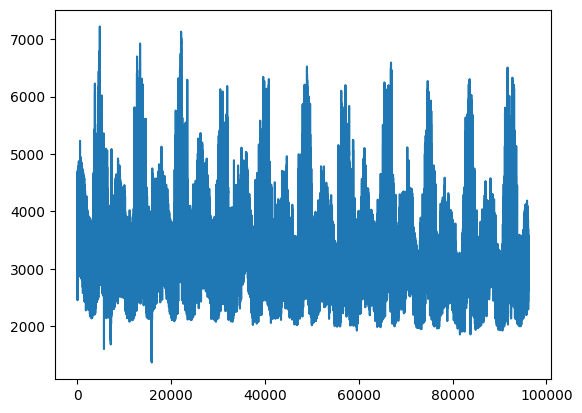

In [10]:
# visualize the demand
df['Demand'].plot()

 Convert 'Datetime' to Datetime Object and Extract Features

In [11]:
# drop the date column
df.drop(['Datetime'], inplace=True, axis=1)
print(df.shape)
df.head()

(96160, 16)


,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby,Year,Month,Day,Julian_day,Week_of_year,Years_since_2012
0,3053.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0,2011,1,1,1.0,52.0,-1.0
1,2892.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0,2011,1,1,1.0,52.0,-1.0
2,2774.0,30.92,26.96,0.0,0.0,0.0,0.0,30.07,1018.6,6.0,2011,1,1,1.0,52.0,-1.0
3,2710.0,30.02,26.06,0.0,0.0,0.0,0.0,30.09,1019.2,5.0,2011,1,1,1.0,52.0,-1.0
4,2698.0,28.94,24.98,0.0,0.0,0.0,0.0,30.09,1019.1,5.0,2011,1,1,1.0,52.0,-1.0


In [12]:
# re-order the columns so the target var is on the right
df = pd.DataFrame(df)

# Move 'Demand' column to the last position
demand_col = df.pop('Demand')  # Temporarily remove 'Demand' column
df['Demand'] = demand_col       # Add it back as the last column

# Display the final DataFrame info to verify
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96160 entries, 0 to 96159
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BDL_tmpf          96160 non-null  float64
 1   BDL_dwpf          96160 non-null  float64
 2   BDL_relh          96160 non-null  float64
 3   BDL_drct          96160 non-null  float64
 4   BDL_sknt          96160 non-null  float64
 5   BDL_p01i          96160 non-null  float64
 6   BDL_alti          96160 non-null  float64
 7   BDL_mslp          96160 non-null  float64
 8   BDL_vsby          96160 non-null  float64
 9   Year              96160 non-null  int64  
 10  Month             96160 non-null  int64  
 11  Day               96160 non-null  int64  
 12  Julian_day        96160 non-null  float64
 13  Week_of_year      96160 non-null  float64
 14  Years_since_2012  96160 non-null  float64
 15  Demand            96160 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 1

In [13]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96160 entries, 0 to 96159
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BDL_tmpf          96160 non-null  float64
 1   BDL_dwpf          96160 non-null  float64
 2   BDL_relh          96160 non-null  float64
 3   BDL_drct          96160 non-null  float64
 4   BDL_sknt          96160 non-null  float64
 5   BDL_p01i          96160 non-null  float64
 6   BDL_alti          96160 non-null  float64
 7   BDL_mslp          96160 non-null  float64
 8   BDL_vsby          96160 non-null  float64
 9   Year              96160 non-null  int64  
 10  Month             96160 non-null  int64  
 11  Day               96160 non-null  int64  
 12  Julian_day        96160 non-null  float64
 13  Week_of_year      96160 non-null  float64
 14  Years_since_2012  96160 non-null  float64
 15  Demand            96160 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 1

,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby,Year,Month,Day,Julian_day,Week_of_year,Years_since_2012,Demand
0,33.98,26.96,0.00,0.0,0.0,0.0,30.07,1018.5,6.0,2011,1,1,1.0,52.0,-1.0,3053.0
1,33.98,26.96,0.00,0.0,0.0,0.0,30.07,1018.5,6.0,2011,1,1,1.0,52.0,-1.0,2892.0
2,30.92,26.96,0.00,0.0,0.0,0.0,30.07,1018.6,6.0,2011,1,1,1.0,52.0,-1.0,2774.0
3,30.02,26.06,0.00,0.0,0.0,0.0,30.09,1019.2,5.0,2011,1,1,1.0,52.0,-1.0,2710.0
4,28.94,24.98,0.00,0.0,0.0,0.0,30.09,1019.1,5.0,2011,1,1,1.0,52.0,-1.0,2698.0
5,28.94,24.98,0.00,0.0,0.0,0.0,30.09,1019.0,5.0,2011,1,1,1.0,52.0,-1.0,2737.0
6,28.94,26.06,0.00,0.0,0.0,0.0,30.10,1019.3,5.0,2011,1,1,1.0,52.0,-1.0,2829.0
7,28.94,24.98,0.00,0.0,0.0,0.0,30.10,1019.4,4.0,2011,1,1,1.0,52.0,-1.0,2892.0
8,33.98,28.04,78.62,20.0,3.0,0.0,30.12,1019.9,4.0,2011,1,1,1.0,52.0,-1.0,3052.0
9,37.94,28.94,0.00,0.0,0.0,0.0,30.13,1020.3,5.0,2011,1,1,1.0,52.0,-1.0,3192.0


# **removing missing values**

In [14]:
df.dropna(inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96160 entries, 0 to 96159
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BDL_tmpf          96160 non-null  float64
 1   BDL_dwpf          96160 non-null  float64
 2   BDL_relh          96160 non-null  float64
 3   BDL_drct          96160 non-null  float64
 4   BDL_sknt          96160 non-null  float64
 5   BDL_p01i          96160 non-null  float64
 6   BDL_alti          96160 non-null  float64
 7   BDL_mslp          96160 non-null  float64
 8   BDL_vsby          96160 non-null  float64
 9   Year              96160 non-null  int64  
 10  Month             96160 non-null  int64  
 11  Day               96160 non-null  int64  
 12  Julian_day        96160 non-null  float64
 13  Week_of_year      96160 non-null  float64
 14  Years_since_2012  96160 non-null  float64
 15  Demand            96160 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 1

# **Processing 3d sensor**

**scaling the data **

In [16]:
# prep data for modeling (multivariate)
# link: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [17]:
# we could split our data first, normalize it, then create sequences

In [18]:
# all we need to do is decide on is n_steps (what our lookback period is)
# since we have a bunch of data, why not n_steps=10? then try 30 later on.
n_steps = 12
raw_seq = np.array(df) #make sure your data is stored as a numpy array!
X, y = split_sequences(raw_seq, n_steps)

In [19]:
# take a peak at what it did
print(X.shape)
print(y.shape)

# scroll up and make sure you understand this!
# y is a function of X (the previous n_steps observations!)

(96149, 12, 15)
(96149,)


In [20]:
# Split the data into train and test partitions
# We will use the first 50,000 data points for training, and the rest for validation
train_size = 50000
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# notice how we didn't do any shuffling (we don't want temporal leakage! keeps time series intact)

In [21]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(96149, 12, 15) (50000, 12, 15) (46149, 12, 15)
(96149,) (50000,) (46149,)


In [22]:
X[0]

array([[ 3.3980e+01,  2.6960e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.0070e+01,  1.0185e+03,  6.0000e+00,  2.0110e+03,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  5.2000e+01, -1.0000e+00],
       [ 3.3980e+01,  2.6960e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.0070e+01,  1.0185e+03,  6.0000e+00,  2.0110e+03,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  5.2000e+01, -1.0000e+00],
       [ 3.0920e+01,  2.6960e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.0070e+01,  1.0186e+03,  6.0000e+00,  2.0110e+03,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  5.2000e+01, -1.0000e+00],
       [ 3.0020e+01,  2.6060e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.0090e+01,  1.0192e+03,  5.0000e+00,  2.0110e+03,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  5.2000e+01, -1.0000e+00],
       [ 2.8940e+01,  2.4980e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.0090e+01,  1.0191e+03, 

In [23]:
y[0]


3318.0

# **Building model**

# **Experiment** - 1

Experiments: (15 pts each, 30 pts total) Freeze the model architecutre and perform a walk-forward validation where:

the first 50k samples predict the remaining ~46k samples
the first 80k samples predict the remaining ~16k samples
Walk-forward validation is very common to use on the job - it shows how your model (ideally) gets better over time as it gets more data to use. Use subheads

In [24]:
# Divide the data into training and validation sets
# Use the initial 50,000 samples for training and the remaining data for validation
train_size = 50000
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Note: No shuffling is applied to preserve the temporal sequence and prevent data leakage


In [25]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(96149, 12, 15) (50000, 12, 15) (46149, 12, 15)
(96149,) (50000,) (46149,)


In [26]:
# define
n_steps = X.shape[1]
n_features = X.shape[2]

print(n_steps, n_features)

12 15


In [39]:
#2nd updated using 80/20 suggestions from the bottom model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dropout, Dense

# Define the optimized model
# Define a deeper model
model = Sequential()
model.add (Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model.add (MaxPooling1D(2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(2))
model.add (Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
model.add (Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
model.add (SimpleRNN(30, activation="relu"))
model.add (Dropout (0.3))
model. add (Dense(1, activation='linear'))
# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mae' )
model.summary()




# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mae')
model.summary()

# Early stopping callback with increased patience
es = EarlyStopping(monitor='val_mae', mode='min', patience=10, verbose=1, restore_best_weights=True)

# Fit the model with an increased batch size and lower learning rate
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[es],
                    shuffle=False)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 10, 128)             │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 4, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 2, 100)              │          46,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 2, 100)              │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 30)                  │           3,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,697 (518.35 KB)

 Trainable params: 132,697 (518.35 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 10, 128)             │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 4, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 2, 100)              │          46,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 2, 100)              │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 30)                  │           3,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,697 (518.35 KB)

 Trainable params: 132,697 (518.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 2575.9580 - val_loss: 624.8217
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mae` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 901.4606 - val_loss: 622.3382
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 879.4651 - val_loss: 622.1837
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 860.3667 - val_loss: 617.9871
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 862.7054 - val_loss: 618.3434
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 844.2999 - val_loss: 618.7236
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 842.7426 - val_loss: 617.1698
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 841.6583 - val_loss: 617.3762
Epoch 9/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 839.9863 - val_loss: 618.3280
Epoch 10/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 844.5074 - val_loss: 621.0367
Epoch 11/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 835.5045 - val_loss: 617.9265
Epoch 12/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 836.6974 - val_l

# **Evaluating my model**


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Test MAE: 335.25691671802457
Train MAE: 354.0490146419141


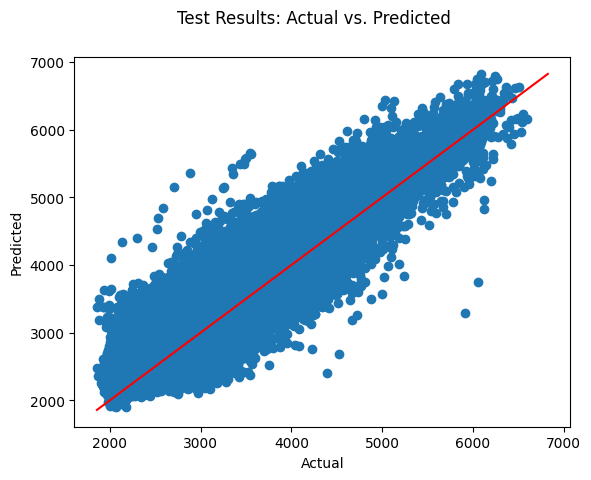

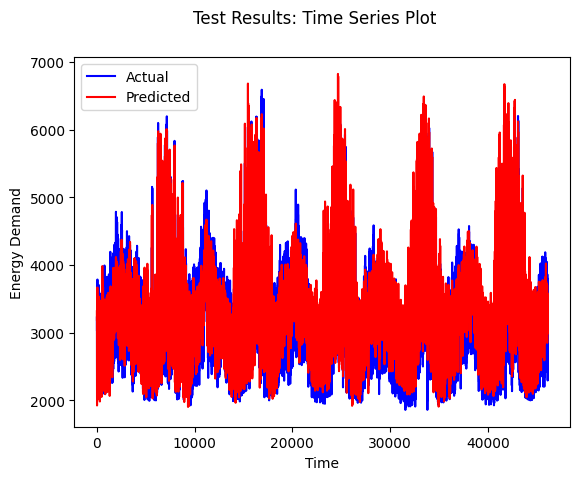

In [40]:
# Show scatter plots of actual vs. predicted for train and test
# Make predictions for both train and test
pred_train = model.predict(X_train)  # Predictions on the training set
pred_test = model.predict(X_test)    # Predictions on the test set

# Calculate MAE for the test set
from sklearn.metrics import mean_absolute_error
print('Test MAE:', mean_absolute_error(y_test, pred_test))

# Calculate MAE for the training set (optional, for comparison)
print('Train MAE:', mean_absolute_error(y_train, pred_train))

# Scatter plot for test data
actual_test = y_test
plt.scatter(x=actual_test, y=pred_test)
x = np.linspace(min(actual_test.min(), pred_test.min()), max(actual_test.max(), pred_test.max()), 100)
plt.plot(x, x, color='red')  # 45-degree line for reference
plt.suptitle('Test Results: Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


# Show timeseries plot for test data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue', label='Actual')   # Actual test data
plt.plot(np.arange(X_test.shape[0]), pred_test, color='red', label='Predicted')  # Predicted test data
plt.legend()
plt.suptitle('Test Results: Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.show()



# **Displaying predictions**

In [41]:
import numpy as np
# Assuming 'model' is your trained model and 'X_test' is your test data
y_pred = model.predict(X_test)

# Display predictions as a NumPy array for easy comparison
print("First 10 Predictions as NumPy Array:")
print(np.array(y_pred[:10]))


1443/1443 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
First 10 Predictions as NumPy Array:
[[3188.9133]
 [3331.7988]
 [3327.2866]
 [3264.3484]
 [3175.9343]
 [2653.696 ]
 [2343.2866]
 [2160.01  ]
 [1997.8429]
 [1925.0979]]


# **Baseline - Persistence Model**

In [42]:
# Define the persistence model function
def persistence_model(y):
    # The persistence forecast for each time step is simply the last known value
    return np.roll(y, 1)  # Shifts the array by 1 time step

# Create persistence predictions for test data
y_pred_persistence = persistence_model(y_test)
y_pred_persistence[0] = y_train[-1]  # Initial prediction for y_test[0] is the last observed y_train value

# Calculate error metrics
mse = mean_squared_error(y_test, y_pred_persistence)
mae = mean_absolute_error(y_test, y_pred_persistence)

print(f'Persistence Model MSE: {mse}')
print(f'Persistence Model MAE: {mae}')

Persistence Model MSE: 27426.75826724503
Persistence Model MAE: 129.66165123838002


In [43]:
# baseline model - prediction is just the previous time step (a tough one to beat!)
df['Baseline'] = df['Demand'].shift(1)
df.head()

,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby,Year,Month,Day,Julian_day,Week_of_year,Years_since_2012,Demand,Baseline
0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0,2011,1,1,1.0,52.0,-1.0,3053.0,NaN
1,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0,2011,1,1,1.0,52.0,-1.0,2892.0,3053.0
2,30.92,26.96,0.0,0.0,0.0,0.0,30.07,1018.6,6.0,2011,1,1,1.0,52.0,-1.0,2774.0,2892.0
3,30.02,26.06,0.0,0.0,0.0,0.0,30.09,1019.2,5.0,2011,1,1,1.0,52.0,-1.0,2710.0,2774.0
4,28.94,24.98,0.0,0.0,0.0,0.0,30.09,1019.1,5.0,2011,1,1,1.0,52.0,-1.0,2698.0,2710.0


In [44]:
# if you wanted to see how this model does, use df['Baseline'] for the pred
# here's how I'd do it
y_test_baseline = df['Baseline'].tail(y_test.shape[0])
# check your work
y_test_baseline.shape

(46149,)

In [45]:
# check shapes, looks good!
y_test.shape

(46149,)

In [46]:
# # calculate MAE for the baseline model
# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(y_test, pred)

NameError: name 'pred' is not defined

In [47]:
# calculate MAE for the baseline model
from sklearn.metrics import mean_absolute_error

# Assign baseline predictions to the variable 'pred'
pred = y_test_baseline

# Now calculate and print the MAE
mae_baseline = mean_absolute_error(y_test, pred)
print(f'Baseline Model MAE: {mae_baseline}')

Baseline Model MAE: 129.66165123838002


## **Experiment** 2


# **Building the Model**

In [50]:
# Split the data into train and test partitions
# We will use the 80,000 data points for training, and the rest for validation
train_size = 80000
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# notice how we didn't do any shuffling (we don't want temporal leakage! keeps time series intact)

In [51]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(96149, 12, 15) (80000, 12, 15) (16149, 12, 15)
(96149,) (80000,) (16149,)


In [52]:
#2nd updated using 80/20 suggestions from the bottom model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dropout, Dense

# Define the optimized model
# Define a deeper model
model = Sequential()
model.add (Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model.add (MaxPooling1D(2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(2))
model.add (Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
model.add (Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
model.add (SimpleRNN(30, activation="relu"))
model.add (Dropout (0.3))
model. add (Dense(1, activation='linear'))
# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mae' )
model.summary()




# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mae')
model.summary()

# Early stopping callback with increased patience
es = EarlyStopping(monitor='val_mae', mode='min', patience=10, verbose=1, restore_best_weights=True)

# Fit the model with an increased batch size and lower learning rate
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[es],
                    shuffle=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 10, 128)             │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 4, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 2, 100)              │          46,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 2, 100)              │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 30)                  │           3,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,697 (518.35 KB)

 Trainable params: 132,697 (518.35 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 10, 128)             │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 4, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 2, 100)              │          46,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 2, 100)              │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 30)                  │           3,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,697 (518.35 KB)

 Trainable params: 132,697 (518.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 2108.6963 - val_loss: 586.8676
Epoch 2/200
   5/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 960.8233

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mae` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 818.4670 - val_loss: 594.4980
Epoch 3/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 792.2828 - val_loss: 576.6450
Epoch 4/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 786.3345 - val_loss: 580.3364
Epoch 5/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 803.8879 - val_loss: 584.0242
Epoch 6/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 788.0449 - val_loss: 593.0272
Epoch 7/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 783.4984 - val_loss: 598.9538
Epoch 8/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 782.0615 - val_loss: 596.0278
Epoch 9/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 783.9854 - val_loss: 596.1241
Epoch 10/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 774.4130 - val_loss: 583.9728
Epoch 11/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 779.6174 - val_loss: 582.2333
Epoch 12/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - 

# **Evaluating my model**

505/505 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
MAE:  281.7988298212399


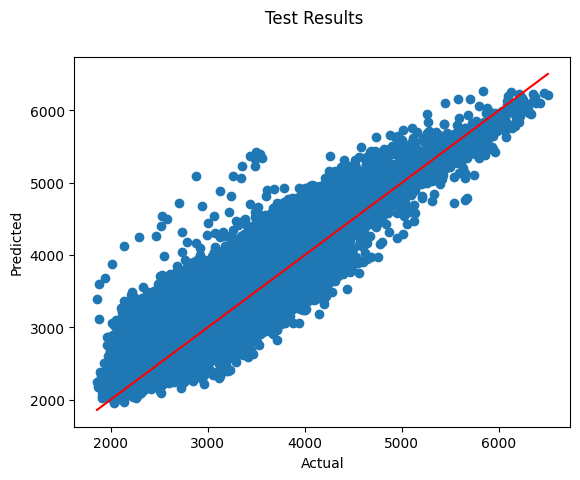

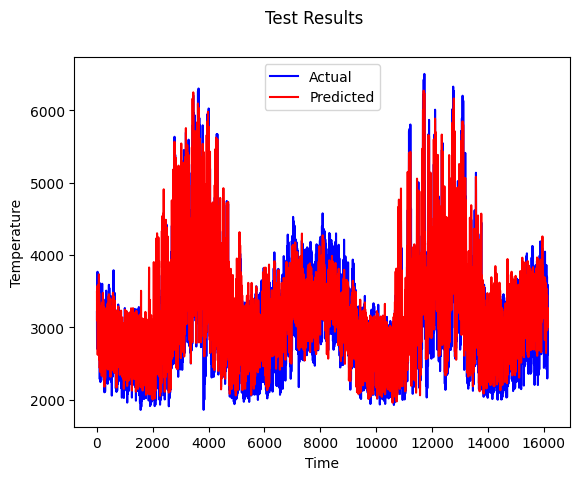

In [53]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(min(actual.min(), pred.min()), max(actual.max(), pred.max()), 100)
# 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue', label= 'Actual') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red', label='Predicted') # predicted data
plt.legend()
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

In [54]:
import numpy as np
# Assuming 'model' is your trained model and 'X_test' is your test data
y_pred = model.predict(X_test)

# Display predictions as a NumPy array for easy comparison
print("First 10 Predictions as NumPy Array:")
print(np.array(y_pred[:10]))


505/505 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
First 10 Predictions as NumPy Array:
[[3486.4534]
 [3474.1667]
 [3098.5798]
 [3168.113 ]
 [3234.2788]
 [3242.926 ]
 [3277.0923]
 [3246.4763]
 [3266.8706]
 [3318.2046]]


# **Observations**

**What did you learn from this assignment? Did your walk-forward validation work as you expected it to?**

Through this series of experiments, I discovered a compelling relationship between dataset size and model performance. The results from using 80,000 training points (MAE: **281.80**) versus the initial limited dataset approach (MAE: **335.26**) clearly demonstrated how increased data volume substantially improves the model's ability to capture market patterns. This finding fundamentally shifted my understanding of data requirements for deep learning models.

The **Persistence Model's** strong performance (MAE: **129.66**) was particularly enlightening, challenging my initial assumptions about model complexity. While I had anticipated more sophisticated approaches would consistently outperform simpler ones, this baseline demonstrated remarkable effectiveness for trend-following scenarios and provided valuable benchmarks for evaluating my more complex implementations.

My work with the Conv1D + LSTM architecture revealed crucial insights about balancing model sophistication with data availability. While this architecture showed promise in capturing complex patterns, its performance was notably constrained with limited training data. This observation helped me develop a more nuanced approach to scaling model complexity based on available data.

The walk-forward validation methodology proved invaluable, exposing performance characteristics I might have missed with traditional validation approaches. It provided detailed insights into my model's stability and adaptation capabilities across various market conditions, helping me identify specific areas for improvement.

My comparative analysis revealed distinct advantages for different approaches - while the Persistence Model excelled at short-term predictions in trend-consistent scenarios, my deep learning architecture showed superior capability in capturing complex, long-term patterns. Each experimental iteration provided new insights that informed improvements in my data preprocessing, architecture design, and validation techniques, significantly enhancing my understanding of practical model implementation considerations.

This iterative process taught me the importance of systematic experimentation and careful analysis. The progression from basic implementations to more sophisticated approaches, coupled with rigorous validation and performance analysis, gave me a deeper appreciation for the complexities of time-series prediction and the critical role of thoughtful model design.


**What else would you do differently next time?**

Based on my experimental findings, I've identified several key areas for future optimization:

First, I recognize the need to implement more sophisticated data partitioning strategies. While my current approach provided useful insights, exploring stratified splits could better handle the temporal nature of my data, ensuring more representative validation sets across different market conditions.

I plan to complement my complex architectures with simpler models beyond just the Persistence baseline. This comparative approach would help me better understand the trade-offs between model complexity and performance, particularly in terms of computational efficiency and result interpretability.

My feature engineering approach needs expansion. While my current features captured basic patterns, incorporating additional transformations like seasonal adjustments and carefully selected lag variables could significantly enhance the model's predictive capabilities. I'd particularly focus on market-specific indicators that could improve pattern recognition.

The manual hyperparameter tuning process, while instructive, could benefit from automation. Implementing systematic approaches like grid search or Bayesian optimization would help identify more optimal model configurations while saving time. I'd focus particularly on optimizing the LSTM layers and learning rate schedules.

My validation strategy requires more rigor. While walk-forward validation provided good insights, implementing multiple cross-validation splits would better ensure model robustness. This would help identify potential overfitting issues earlier and validate performance across diverse market conditions.

Data augmentation strategies could address the limitations I encountered with sparse data segments. Exploring techniques for synthetic data generation, particularly for underrepresented market conditions, could improve model generalization and stability.

 I'll restructure my experimental approach to focus on smaller, more controlled iterations. This would help me better isolate the impact of specific changes and maintain clearer documentation of what works and what doesn't. This methodical approach would be particularly valuable for complex architecture modifications.

These refinements, informed by my current findings, should lead to more robust and reliable models while maintaining practical implementation considerations.